In [124]:

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import os 
from scipy.integrate import  simpson
from scipy.optimize import curve_fit
from scipy.constants import epsilon_0, mu_0
sys.path.append("C:\\Program Files\\Lumerical\\v242\\api\\python") # this line is to direct the python script ot the lumerical python api 
import lumapi

current_directory= os.getcwd()
current_directory= r"{}".format(current_directory)
sys.path.append(current_directory)

focal_length = 100.0e-6
LensDiameter= 20.0e-6
SubstrateIndex= 1.46 
PillarIndex= 3.4757
period = 0.4e-6 
wavelength = 1.55e-6

unit_cell_library_file_name= 'EH_and_phase_vs_radius_interp_fdtd_si_sio2_sept13.mat'
zemax_phase_file_name=  'output_x_y_rad_apexPHAZE_optimized.txt'

In [177]:
# Define the Gaussian function
def gaussian(x, amp, mean, stddev):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def integrate2D(A, x, y):
     return simpson(y=simpson(y=A, x=x), x=y)



In [91]:
fdtd= lumapi.FDTD()

setup_script= """
# create an aperture matching the diameter of the metalens 
R = getnamed("metalens","lens_radius");
W = getnamed("metalens::substrate","x span");
V = R*exp(1i*linspace(0,2*pi,200));
V = [W/2,0; W/2,-W/2; -W/2,-W/2; -W/2,W/2; W/2,W/2; W/2,0; real(V),imag(V)];
setnamed("aperture","vertices",V);
"""
fdtd.set("setup script",  setup_script)

radius_phase_file = current_directory+ '\\2_meta_library\\unit cell'+'\\' + unit_cell_library_file_name
zfile= current_directory+ '\\'+ zemax_phase_file_name

# #==================================================
# Add FDTD
# #==================================================
fdtd.addfdtd()
fdtd.set("dimension",2);  #  1 = 2D, 2 = 3D
fdtd.set("x",0)
fdtd.set("x span",25.0e-6)
fdtd.set("y",0)
fdtd.set("y span",25.0e-6)
fdtd.set("z",0.6e-6)
fdtd.set("z span",1.8e-6)
fdtd.set("mesh type", "auto non-uniform")
fdtd.set("mesh accuracy", 3)



# create an aperture matching the diameter of the metalens 
# myscript= """
# R = getnamed("metalens","lens radius");
# W = getnamed("metalens::substrate","x span");
# V = R*exp(1i*linspace(0,2*pi,200));
# V = [W/2,0; W/2,-W/2; -W/2,-W/2; -W/2,W/2; W/2,W/2; W/2,0; real(V),imag(V)];
# setnamed("aperture","vertices",V);
# """
# fdtd.set("script",myscript)

# #==================================================
# Add the metalens geometry 
# #==================================================
fdtd.addstructuregroup()
fdtd.set("name", "metalens")
fdtd.adduserprop("radius_vs_phase_data_file", 1, radius_phase_file)
fdtd.adduserprop("zemax_optimized_phase_file", 1,zfile)
fdtd.adduserprop("focal_length", 2, focal_length)
fdtd.adduserprop("lens_radius", 2, LensDiameter/2)
fdtd.adduserprop("substrate_index", 0, SubstrateIndex)
fdtd.adduserprop("pillar_index", 0, PillarIndex)



myscript =f"""deleteall;
matlabload(radius_vs_phase_data_file);
?mat_sub;
np = round({LensDiameter/2}/ {period});
x_mask = period * (-np:1:np);
y_mask = period * (-np:1:np);

addrect; # substrate
set("name", "substrate");
set("index",substrate_index);

# ## set("material", "sio2");
# if (mat_sub=="<Object defined dielectric>") {{
#     set("index",substrate_index);
# }}

set("x span",3*max(x_mask));
set("y span",3*max(x_mask));
set("z max",0);
set("z min",-2*{wavelength});

M=readdata(zemax_optimized_phase_file);
len= length(M)/3;
for(i=1:len) {{
    addcircle({{"name":"pillar", "x":M(i),"y":M(len+i),"radius":M(2*len+i)}});
}}
select("pillar");
set("index",index_pillar);
# set("material", "si");


set("z min",0);
set("z max",1.3e-6);
?height;
"""

fdtd.set("script", myscript)

# #==================================================
# Add the aperture
# #==================================================

fdtd.add2dpoly()
fdtd.set("name", "aperture")
fdtd.set("z", -0.05e-6)
R = LensDiameter/2
W = 3* 10e-6
apertureP= np.linspace(0, 2*np.pi, 200)
V = R*np.exp(complex(0,1)* apertureP)
#V = [W/2,0; W/2,-W/2; -W/2,-W/2; -W/2,W/2; W/2,W/2; W/2,0; real(V),imag(V)];
#fdtd.set("vertices", "[1.0e-6, 2.0e-6; 1.5e-6,2.0e-6]")
#  setnamed("aperture","vertices",V);

# #==================================================
# Add the source 
# #==================================================
fdtd.addplane()
fdtd.set("name", "source")
fdtd.set("injection axis","z")
fdtd.set("direction","forward")
fdtd.set("x",0)
fdtd.set("x span",30.0e-6)

fdtd.set("y",0)
fdtd.set("y span",30.0e-6)

fdtd.set("z",-0.15e-6)

fdtd.set("center wavelength", 1.55e-6)
fdtd.set("wavelength span",0.0e-6)

# #==================================================
# Add the FIELD monitor
# #==================================================
fdtd.addpower()
fdtd.set("name","field")
fdtd.set("monitor type",7)  # 2D z-normal
fdtd.set("x",0)
fdtd.set("x span",25.0e-6)
fdtd.set("y",0)
fdtd.set("y span",25.0e-6)
fdtd.set("z",1.365e-6)
# #==================================================

# #==================================================
# Add the Transmission monitor
# #==================================================
fdtd.addprofile()
fdtd.set("name","transmission")
fdtd.set("monitor type",7)  # 2D z-normal
fdtd.set("x",0)
fdtd.set("x span",25.0e-6)
fdtd.set("y",0)
fdtd.set("y span",25.0e-6)
fdtd.set("z",1.365e-6)
fdtd.set("output Pz", True)

fdtd.setglobalmonitor("frequency points", 1) # setting the global frequency resolution
fdtd.save("lumerical_full_lens_test")
fdtd.run()

In [178]:
fdtd= lumapi.FDTD()
fdtd.load("lumerical_full_lens_test.fsp")
# #====================================================
monitor_name="transmission"
fdtd.getdata(monitor_name,"f")
T1=fdtd.transmission(monitor_name)
print(f"normalized power through surface near the metalens (using direct transmission): {T1}")

# #=====================================================
# Calculate the power using Poynting vector Pz
# #=====================================================
# second way to calculate power through a surface - transmission
x=fdtd.getdata(monitor_name,"x")
y=fdtd.getdata(monitor_name,"y")
f=fdtd.getdata(monitor_name,"f")
Pz=fdtd.getdata(monitor_name,"Pz")
SourcePower= fdtd.sourcepower(f)



Pz_real= np.real(Pz)
Pz_real= np.squeeze(Pz_real)
x= np.squeeze(x)
y= np.squeeze(y)


T_Poynting= (integrate2D(Pz_real, x, y)* 0.5)/ SourcePower
print(f"normalized power through surface near the metalens (by using Poynting vector): {T_Poynting}")


# #=====================================================
# Calculate the Focal Length 
# #=====================================================

# choose area to plot and spatial resolution
x = np.linspace(-LensDiameter/2,LensDiameter/2,200)
y = np.linspace(-LensDiameter/2,LensDiameter/2,200)
z = np.linspace(1e-6,1.5*focal_length,100)



# get the focal length 
farfield_E_along_z = fdtd.farfieldexact3d(monitor_name,0,0,z)
farfield_E_along_z= np.squeeze(farfield_E_along_z)
farfield_E2_z= abs(farfield_E_along_z)**2 # E^2
farfield_E2_z= farfield_E2_z[:,0] # this is the actual farfield e2_z
focal_calculated= z[np.where(farfield_E2_z== max(farfield_E2_z))[0]]


# #=====================================================
# Calculate the FWHM of the beam 
# #=====================================================
EFocal = fdtd.farfieldexact3d('field', x, y, focal_calculated, {"field":"E"})
farfield_E_along_x_at_focal = fdtd.farfieldexact3d(monitor_name,x,0, focal_calculated)
farfield_E_along_x_at_focal= np.squeeze(farfield_E_along_x_at_focal)
farfield_E2_x= abs(farfield_E_along_x_at_focal)**2 # Ex^2
farfield_E2_x= farfield_E2_x[:,0] # this is the actual farfield e2_x



# Calculate initial guess for the parameters
initial_amplitude = np.max(farfield_E2_x)  # Amplitude as the maximum value in the data
initial_mean = x[np.argmax(farfield_E2_x)]  # Mean as the x-value at the maximum y-value
initial_stddev = np.std(x)  # Standard deviation, can be adjusted based on data spread

# Combine into an initial guess
initial_guess = [initial_amplitude, initial_mean, initial_stddev]

# Fit the Gaussian to the data
popt, pcov = curve_fit(gaussian, x, farfield_E2_x, p0=initial_guess)

# Extract the fitted parameters
amplitude, mean, stddev = popt

# Calculate FWHM
fwhm = 2 * np.sqrt(2 * np.log(2)) * stddev
# #=====================================================
# #=====================================================
# Total power through the FOCAL PLANE
# #=====================================================
farfield_E_total= fdtd.farfieldexact3d('field', x, y, focal_calculated, {"field":"E"})
farfield_E_total= np.squeeze(farfield_E_total)
Ex= farfield_E_total[:,:,0]
Ey= farfield_E_total[:,:,1]
Ez= farfield_E_total[:,:,2]
E_squared= abs(Ex)**2+ abs(Ey)**2



TotalPower = 0.5* integrate2D(E_squared, x, y)* np.sqrt(epsilon_0/mu_0)


# #=====================================================
# Total power through the FOCAL SPOT (2* FWHM radius)
# #=====================================================

FocalSpotRadius= 2* fwhm
# Generate meshgrid
X, Y = np.meshgrid(x, y)
x_center= 1e-6 
y_center= 1e-6 

# Calculate the distance from the center
distances = np.sqrt((X - x_center)**2 + (Y - y_center)**2)

# Create the filter
filter_mask = (FocalSpotRadius >= distances)

# Apply the filter to I_Focal
I_Focal_filtered = filter_mask *E_squared





PowerAtFocalSpot=  (0.5* integrate2D(I_Focal_filtered, x, y)* np.sqrt(epsilon_0/mu_0))
# #=====================================================
# Efficiency Calculation
# #=====================================================

OverallEfficiency= PowerAtFocalSpot/ SourcePower
FocusingEfficiency= OverallEfficiency/ T_Poynting

print(f"Focal Length: {focal_calculated[0]* 1e6} μm, \nFWHM: {fwhm* 1e6} μm, \nOverall Efficiency:{OverallEfficiency}, \nFocusing Efficiency: {FocusingEfficiency}, \nTransmission Efficiency: {T1}")



normalized power through surface near the metalens (using direct transmission): 0.4802712378767722
normalized power through surface near the metalens (by using Poynting vector): 0.4802697277654697
Focal Length: 55.18181818181819 μm, 
FWHM: 5.0013570110566805 μm, 
Overall Efficiency:0.41233939466341074, 
Focusing Efficiency: 0.8585579536355216, 
Transmission Efficiency: 0.4802712378767722


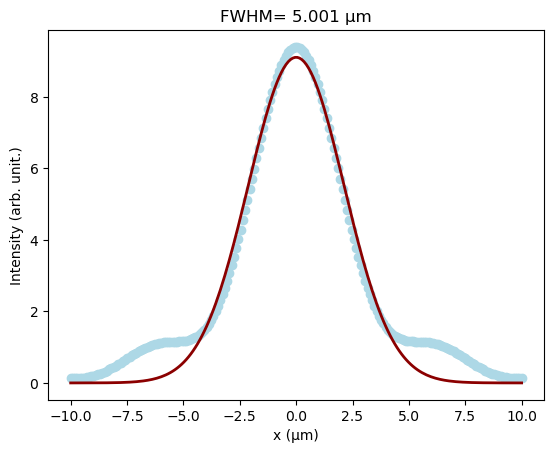

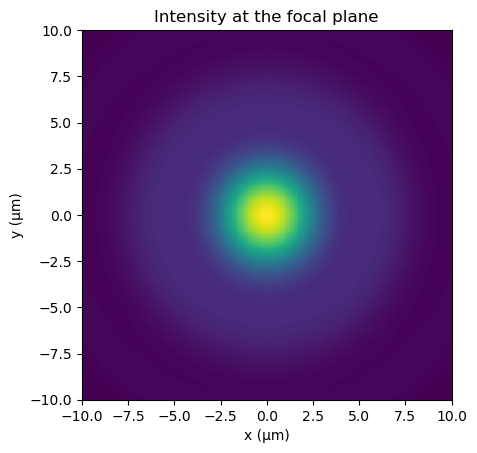

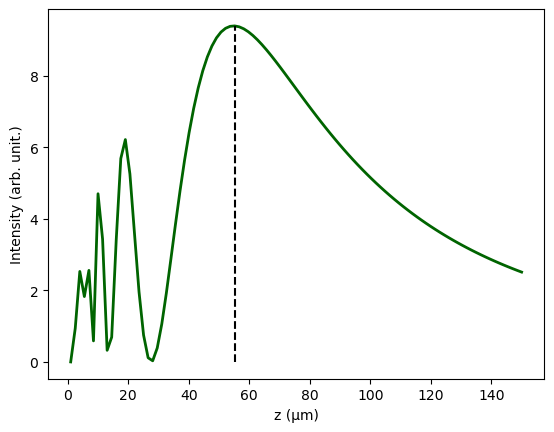

In [198]:

# #=====================================================
# plot FWHM
# #=====================================================
plt.scatter(x*1e6, farfield_E2_x, label='X Intensity at the focal spot', color='lightblue')
plt.plot(x*1e6, gaussian(x, *popt), label='Fitted Gaussian', color='darkred', linewidth = 2)
plt.xlabel('x (μm)')
plt.ylabel('Intensity (arb. unit.)')
plt.title(f"FWHM= {round(fwhm*1e6,3)} μm")
plt.show()
#=====================================================


# #=====================================================
# plot Intensity at focal plane 
# #=====================================================
# Intensity plot at the focal plane 
extent = [np.min(x), np.max(x), np.min(y), np.max(y)]
extent= [i* 1e6  for i in extent]
plt.imshow(E_squared, cmap ="viridis", interpolation ='nearest', extent= extent)
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.title('Intensity at the focal plane')
plt.show()


# #=====================================================
# Plot intensity along z-axis 
# #=====================================================
plt.plot(z*1e6, farfield_E2_z, linewidth = 2, color= 'darkgreen')
plt.vlines(x= focal_calculated*1e6, ymin= min(farfield_E2_z), ymax=max(farfield_E2_z), linestyle= '--', color= 'black')
plt.xlabel('z (μm)')
plt.ylabel('Intensity (arb. unit.)')
plt.show()